#### Library Imports

In [ ]:
# Import required libraries

# For mathematical operations
import numpy as np

# For data manipulation
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
import imblearn
from imblearn.over_sampling import SMOTE

# For OS operations
from pathlib import Path
import sys
import logging

#### Data Viz Settings

In [ ]:
# Setting up the Figure Size
plt.rcParams['figure.figsize'] = [16, 5]

# Setting Plot Theme
plt.style.use('seaborn-v0_8-whitegrid')



#### Operational Settings

In [ ]:
# Setting up Project Paths
main_directory_path = Path.cwd().parent
data_directory_path = main_directory_path / 'data'

# Remove any existing handlers associated with the logger
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Test logging
# logger.info("This is an info message")
# logger.error("This is an error message")


#### Data Imports

In [ ]:
# Reading the datasets
try:
    logger.info('Reading the datasets..')
    train = pd.read_csv(data_directory_path / 'train.csv')
    test = pd.read_csv(data_directory_path / 'test.csv')
except FileNotFoundError:
   logger.error('Datasets not found. Please check the file path and try again.')
   sys.exit(1)
finally:
    logger.info('Datasets loaded successfully.')

2024-10-04 10:36:13,301 - INFO - Reading the datasets..
2024-10-04 10:36:13,358 - INFO - Datasets loaded successfully.


#### Inspecting the datasets

In [ ]:
# Getting to know the `Train` dataset
print(train.shape)
train.head()

(54808, 14)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
# Getting to know the `Test` dataset
print(test.shape)
test.head()

(23490, 13)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


##### *Initial Inspection thoughts*...

**Note:**
* `Train` DF contains 14 colunmns vs `Test` has 13. This is because `Train` contains the dependent variable, `is_promoted` column, which our `Test` DF will be solving for.

**Columns to keep:**
* `id`: No
* `department`: Yes
* `region`: no
* `education`: Yes
* `gender`: Shouldn't be important; but need to test.
* `recruitment_channel`: No
* `no_of_trainings`: Yes
* `age`: Yes
* `previous_year_rating`: Yes
* `length_of_service`: Yes
* `KPIs_met>80%`: Yes
* `awards_won`: Yes
* `avg_training_score`: Yes

#### Descriptive Statistics of the `Train` dataset

In [ ]:
# Examining Continous Variables
train.describe(include='number')

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


##### *Continous Variables Findings*...
* No outliers present in important variables
  * Variables such as `avg_training_score`, `length_of_service`, `previous_year_rating` all look well-distributed.
* Mean of `is_promoted` skews closer to 1 (.085); which is cause for further investigation, as an imbalanced dataset can harm the model.

In [ ]:
# Examining Categorical Variables
train.describe(include='object')

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


#### Target Variable Class Balance
* When checking the descriptive statistics of the `Train` df, it was discovered that the mean of the target variable, `is_promoted` skewed closer to 1 (.085); which was cause for further investigation, as an imbalanced dataset can harm the model.

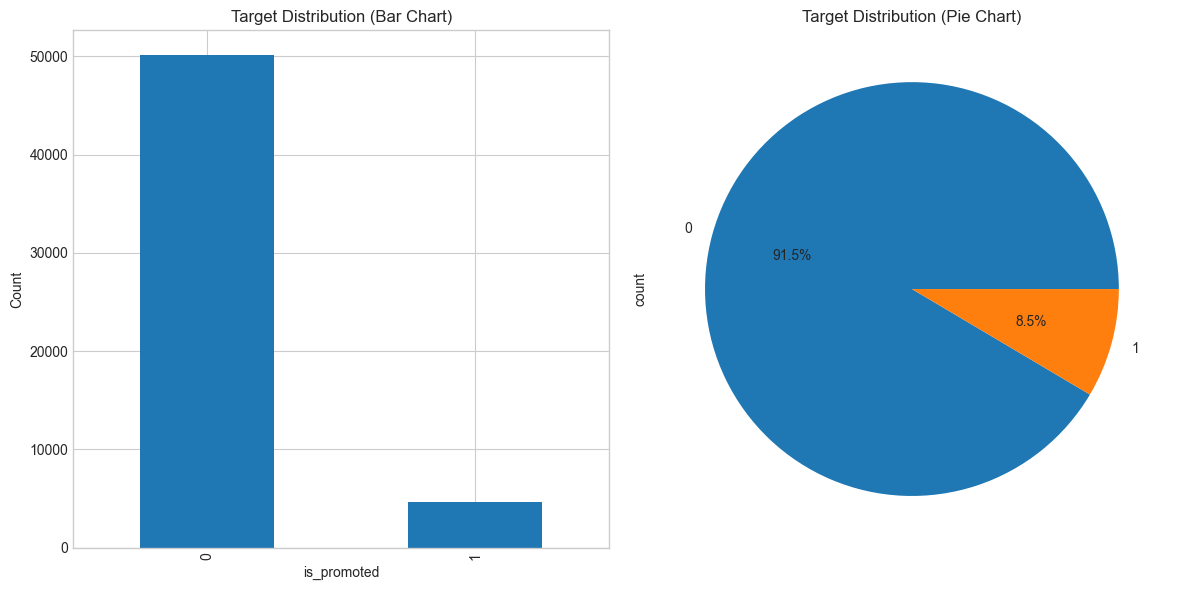

In [ ]:
# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


# Plot the bar chart in the first subplot
train.value_counts('is_promoted').plot(
    kind='bar',
    ax=axes[0],
    title='Target Distribution (Bar Chart)',
    ylabel='Count'
    )


# Plot the pie chart in the second subplot
train.value_counts('is_promoted').plot(
    kind='pie',
    ax=axes[1],
    title='Target Distribution (Pie Chart)',
    autopct='%1.1f%%'
    )

# Display the combined figure
plt.tight_layout()
plt.show()


##### *Target Class Balance Findings*...
* The target variable class is highly unbalanced: `0 = 91.5%` vs `1 = 8.5%`.
  * Cannot deploy the machine learning model as-is, as it will be very biased towards the class which has the higher distibution -- in this case `0` aka **no promotion**.
    * So, to move forward, we must balance the class by treating it with statistical resampling.

#### Missing Values Treatment

In [ ]:
# Calculating missing values in Training and Test datasets
train_total = train.isnull().sum()
test_total = test.isnull().sum()

# Calculating the percentage of missing values
train_percent = ((train.isnull().sum()/train.shape[0])*100).round(2)
test_percent = ((test.isnull().sum()/test.shape[0])*100).round(2)

# Creating a dataset consisting of the of the total number of missing value and percentage of missing values in the dataset
train_missing_data = pd.concat(
    [
        train_total,
        train_percent,
        test_total,
        test_percent
    ],
    axis=1,
    keys=['Train_Total', 'Train_Percent %','Test_Total', 'Test_Percent %'],
    sort = True
    )

# lets check the head
train_missing_data

,Train_Total,Train_Percent %,Test_Total,Test_Percent %
KPIs_met >80%,0,0.00,0.0,0.00
age,0,0.00,0.0,0.00
avg_training_score,0,0.00,0.0,0.00
awards_won?,0,0.00,0.0,0.00
department,0,0.00,0.0,0.00
education,2409,4.40,1034.0,4.40
employee_id,0,0.00,0.0,0.00
gender,0,0.00,0.0,0.00
is_promoted,0,0.00,NaN,NaN
length_of_service,0,0.00,0.0,0.00


We can see from the above table, that only two columns have missing values in both the Train and Test Datasets, `education`, and `previous_year_rating`. The Percentage of Missing values are:
* 4% for `education`
* 7% for `previous_year_rating`
  
Upon analyzing these numbers, it appears it won't be necessary to delete missing values, but instead will be able to impute them using Mean, Median, and Mode.

#### *Imputing Missing Values:*
* Imputing missing values for the `education` column for both Test and Train datasets.

In [ ]:
# View the values that make up the education column
train.education.value_counts()

# View the `mode` of the education column
# Notice value is returned as an array at position 0
train.education.mode()

# Impute the missing `education` values with the Mode, which is `Bachelor's`
train.education = train.education.fillna(train.education.mode()[0])

# Verify values were imputed correctly by rechecking misisng values
print("Missing values in the TRAIN DATASET after imputation: ",train.education.isnull().sum())

Missing values in the TRAIN DATASET after imputation:  0


In [ ]:
# View the values that make up the education column
test.education.value_counts()

# View the `mode` of the education column
# Notice value is returned as an array at position 0
test.education.mode()

# Impute the missing `education` values with the Mode, which is `Bachelor's`
test.education = test.education.fillna(test.education.mode()[0])

# Verify values were imputed correctly by rechecking misisng values
print("Missing values in the TEST DATASET after imputation: ",test.education.isnull().sum())

Missing values in the TEST DATASET after imputation:  0


* Imputing missing values for the `previous_year_rating` column for both Test and Train datasets.

In [ ]:
# View the values that make up the previous_year_rating column
train.previous_year_rating.value_counts()

# View the `mode` of the previous_year_rating column
# Notice value is returned as an array at position 0
train.previous_year_rating.mode()

# Impute the missing `previous_year_rating` values with the Mode, which is `Bachelor's`
train.previous_year_rating = train.previous_year_rating.fillna(train.previous_year_rating.mode()[0])

# Verify values were imputed correctly by rechecking misisng values
print("Missing values in the TRAIN DATASET after imputation: ",train.previous_year_rating.isnull().sum())

Missing values in the TRAIN DATASET after imputation:  0


In [ ]:
# View the values that make up the previous_year_rating column
test.previous_year_rating.value_counts()

# View the `mode` of the previous_year_rating column
# Notice value is returned as an array at position 0
test.previous_year_rating.mode()

# Impute the missing `previous_year_rating` values with the Mode, which is `Bachelor's`
test.previous_year_rating = test.previous_year_rating.fillna(test.previous_year_rating.mode()[0])

# Verify values were imputed correctly by rechecking misisng values
print("Missing values in the TEST DATASET after imputation: ",test.previous_year_rating.isnull().sum())

Missing values in the TEST DATASET after imputation:  0


*Missing values have been imputed for both the Test and Train Dataset, by using the Mode values of each respective column -- even for the `previous year rating`, column which seems to be numerical, but in reality, is also categorical.
This completes the Treatment of the Missing Values for both datasets*

#### Outlier Detection

**Steps**
1. Separate and view numeric-type columns in the dataset in order to select and further inspect columns that will have more of a propensity towards having outliers.

In [ ]:
# Examining Continous Variables
train.describe(include='number')

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


2. Columns selected for outliers are:
   1. `no_of_trainings`
   2. `length_of_service`
   3. `avg_training_score`
3. Plot and analyze selected variables using a box plot


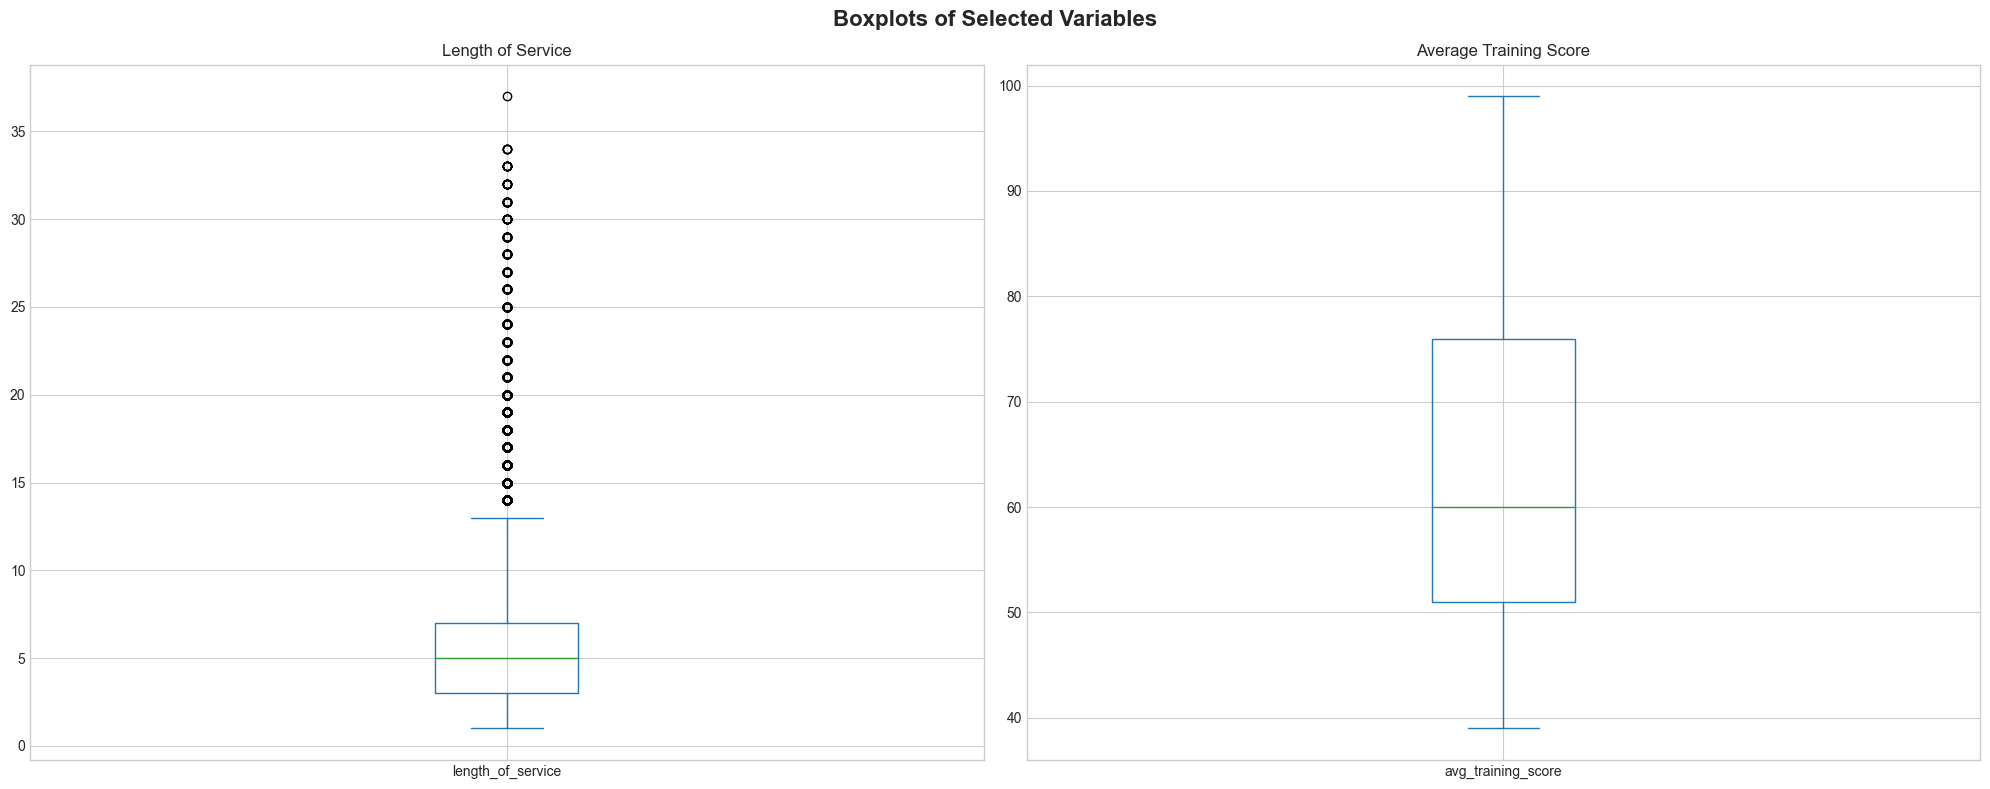

In [ ]:
# 3. Plotting selected variable using box plots
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
train.length_of_service.plot(kind='box', title='Length of Service')

plt.subplot(1, 2, 2)
train.avg_training_score.plot(kind='box', title='Average Training Score')

plt.suptitle('Boxplots of Selected Variables', fontsize=16, fontweight='bold'),
plt.tight_layout()

4. Treat the outliers by removing them from the `length_of_service` column

In [ ]:
# 4. Removing Outliers
train = train[train['length_of_service'] <= 13]

5. Double check the variables were removed

<Axes: title={'center': 'Length of Service'}>

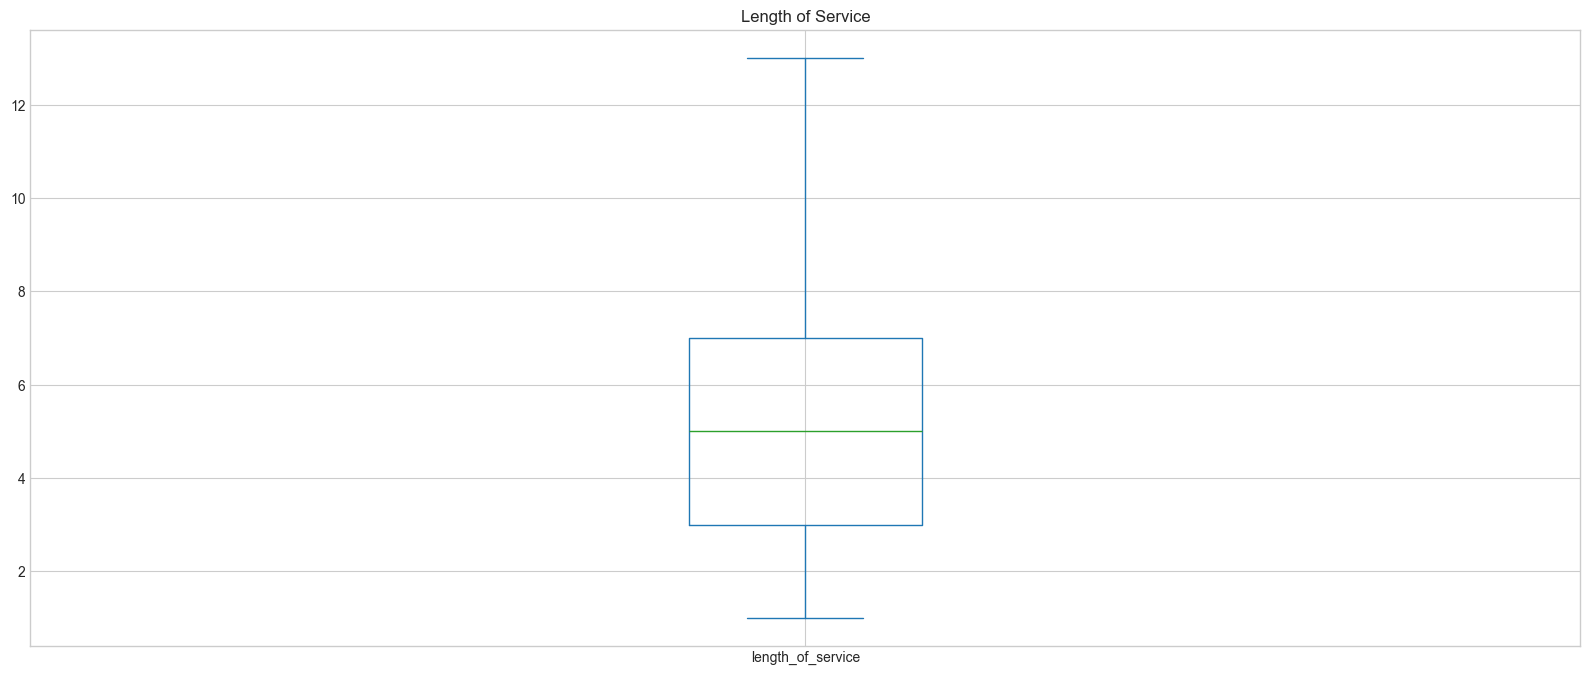

In [ ]:
# 5. Double checking the box plot to ensure outliers were removed
train.length_of_service.plot(kind='box', title='Length of Service')

#### Univariate Analysis

* This is an essential step, to understand the variables present in the dataset one by one. Things to check:
* Use Univariate Analysis to analyze numerical columns to check for outliers using distribution plots, box charts, bar charts, and pie charts for both numerical and categorical data.

<Axes: title={'center': 'Recruitment Channel'}, ylabel='count'>

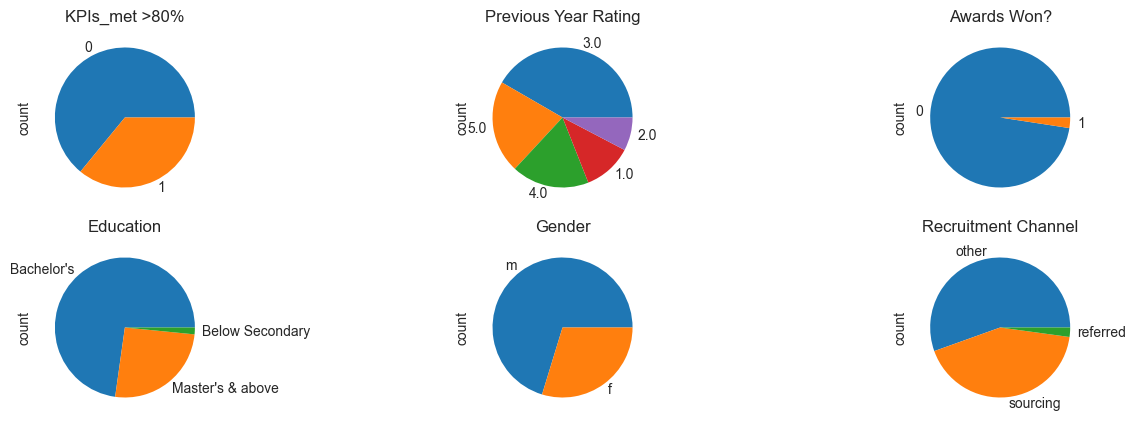

In [ ]:
# Creating Pie Charts to check Distributions of Categorical Plots
plt.subplot(2, 3, 1)
train['KPIs_met >80%'].value_counts().plot(kind='pie', title='KPIs_met >80%')

plt.subplot(2, 3, 2)
train['previous_year_rating'].value_counts().plot(kind='pie', title='Previous Year Rating')

plt.subplot(2, 3, 3)
train['awards_won?'].value_counts().plot(kind='pie', title='Awards Won?')

plt.subplot(2, 3, 4)
train['education'].value_counts().plot(kind='pie', title='Education')

plt.subplot(2, 3, 5)
train['gender'].value_counts().plot(kind='pie', title='Gender')

plt.subplot(2, 3, 6)
train['recruitment_channel'].value_counts().plot(kind='pie', title='Recruitment Channel')

#### *Findings*
* Less than half of employees meet 80% or more of their set KPIs.
* Most of the Employees have a very low previous year rating
* Very few employees win awards for their work.
* Very few employees have only a high school education
* There are less female employees than males
* Very few referred employees; most recruiment seems to be happening through other channels.

In [1]:
# Bar Charts
plt.subplot(1, 3, 1)
train['no_of_trainings'].value_counts(ascending=True).plot(kind='barh', title='No of Trainings')

plt.subplot(1, 3, 2)
train['department'].value_counts(ascending=True).plot(kind='barh', title='Department')

plt.subplot(1, 3, 3)
train['region'].value_counts(ascending=True).plot(kind='barh', title='Region')



NameError: name 'plt' is not defined

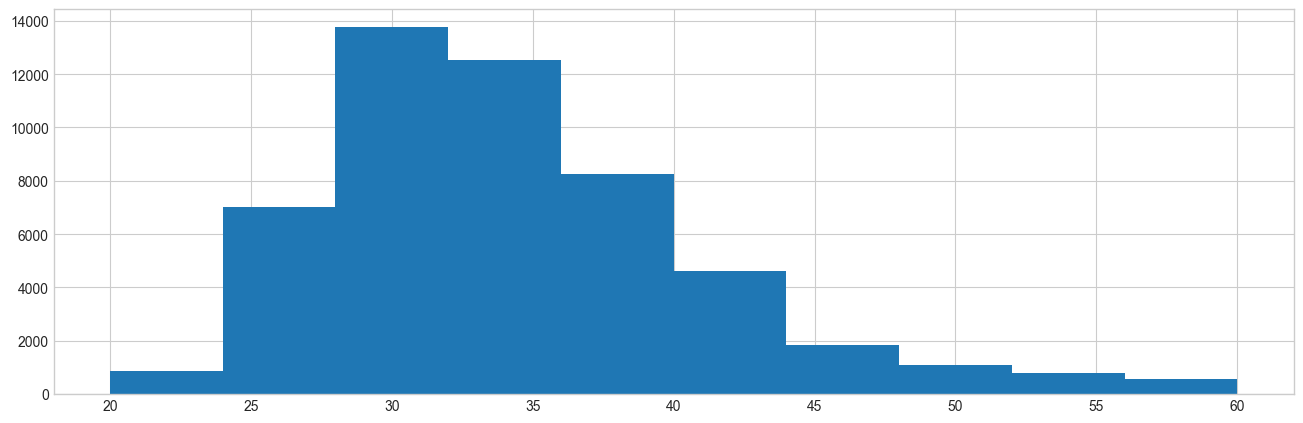

In [ ]:
# Histogram
plt.hist(train['age'], bins=10, label='Age')
plt.show()

#### Bivariate Analysis
Bivariate analysis is one of the simplest forms of quantitative analysis. It involves the analysis of two variables, for the purpose of determining the empirical relationship between them. Bivariate analysis can be helpful in testing simple hypotheses of association.

    
In this section, bivariate analysis will be used to create
* Crosstab analysis, bar charts, box plots, scatter plots, etc. on variables to be able to derive insights.

<Axes: xlabel='gender'>

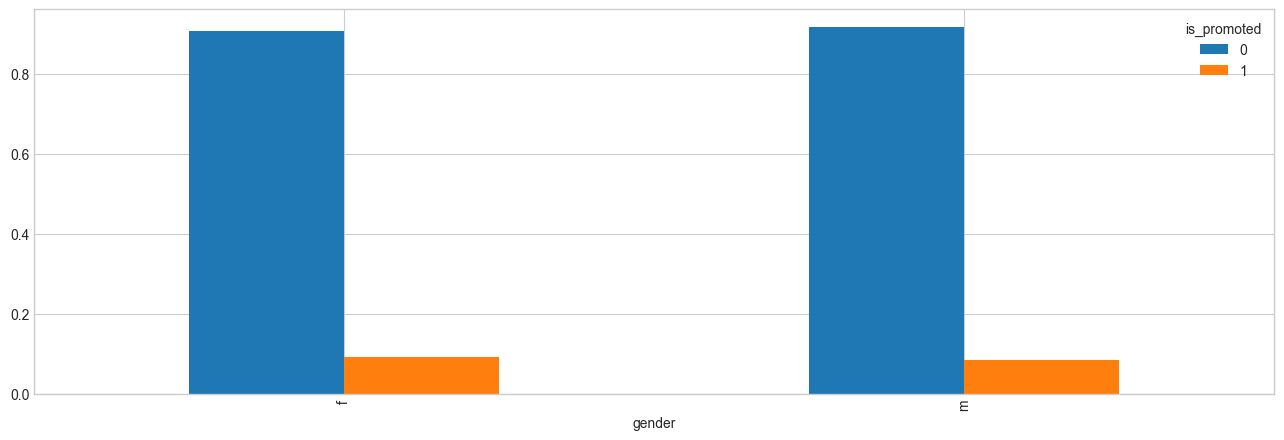

In [ ]:
# Viewing a cross tab of promotion rates by gender to check for uneven distribution
x = pd.crosstab(train['gender'], train['is_promoted'])
# x

x.div(x.sum(1).astype(float), axis=0).plot(kind='bar', stacked=False)


#### Finindings:
Despite there being a lesser amount of females working at the company compared to males,  when it comes to promotion, there is no evidence of unfair promotion rates attributed to gender. Females are promoted at the same rate.

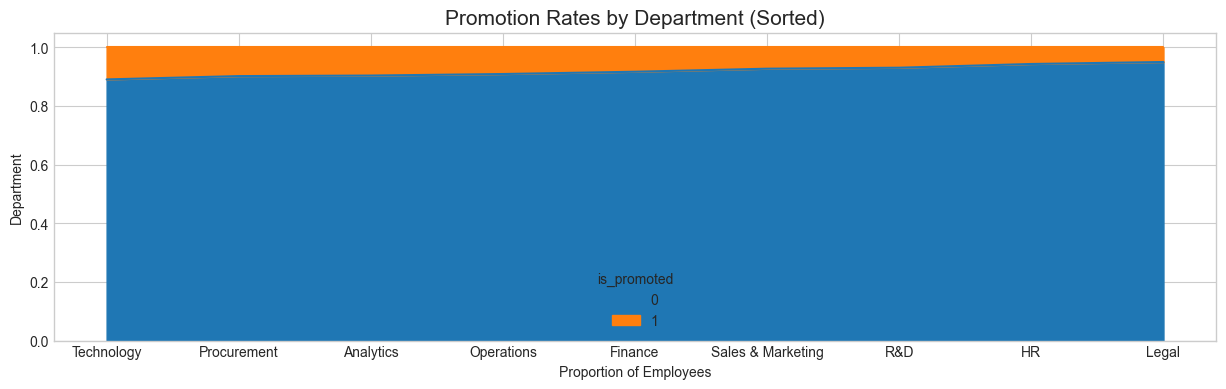

In [ ]:
# Cross tab of promotion rate across different departments of the organization
x = pd.crosstab(train['department'], train['is_promoted'])
# x

normalized_x = x.div(x.sum(1).astype(float), axis=0)
sorted_x = normalized_x.sort_values(by=1, ascending=False)
# sorted_x.plot(kind='barh')
sorted_x.plot(kind='area')
plt.title('Promotion Rates by Department (Sorted)', fontsize=15)
plt.xlabel('Proportion of Employees')
plt.ylabel('Department')
plt.show()



Findings:
* For the most part, all departments have a very similar rate of promotion.

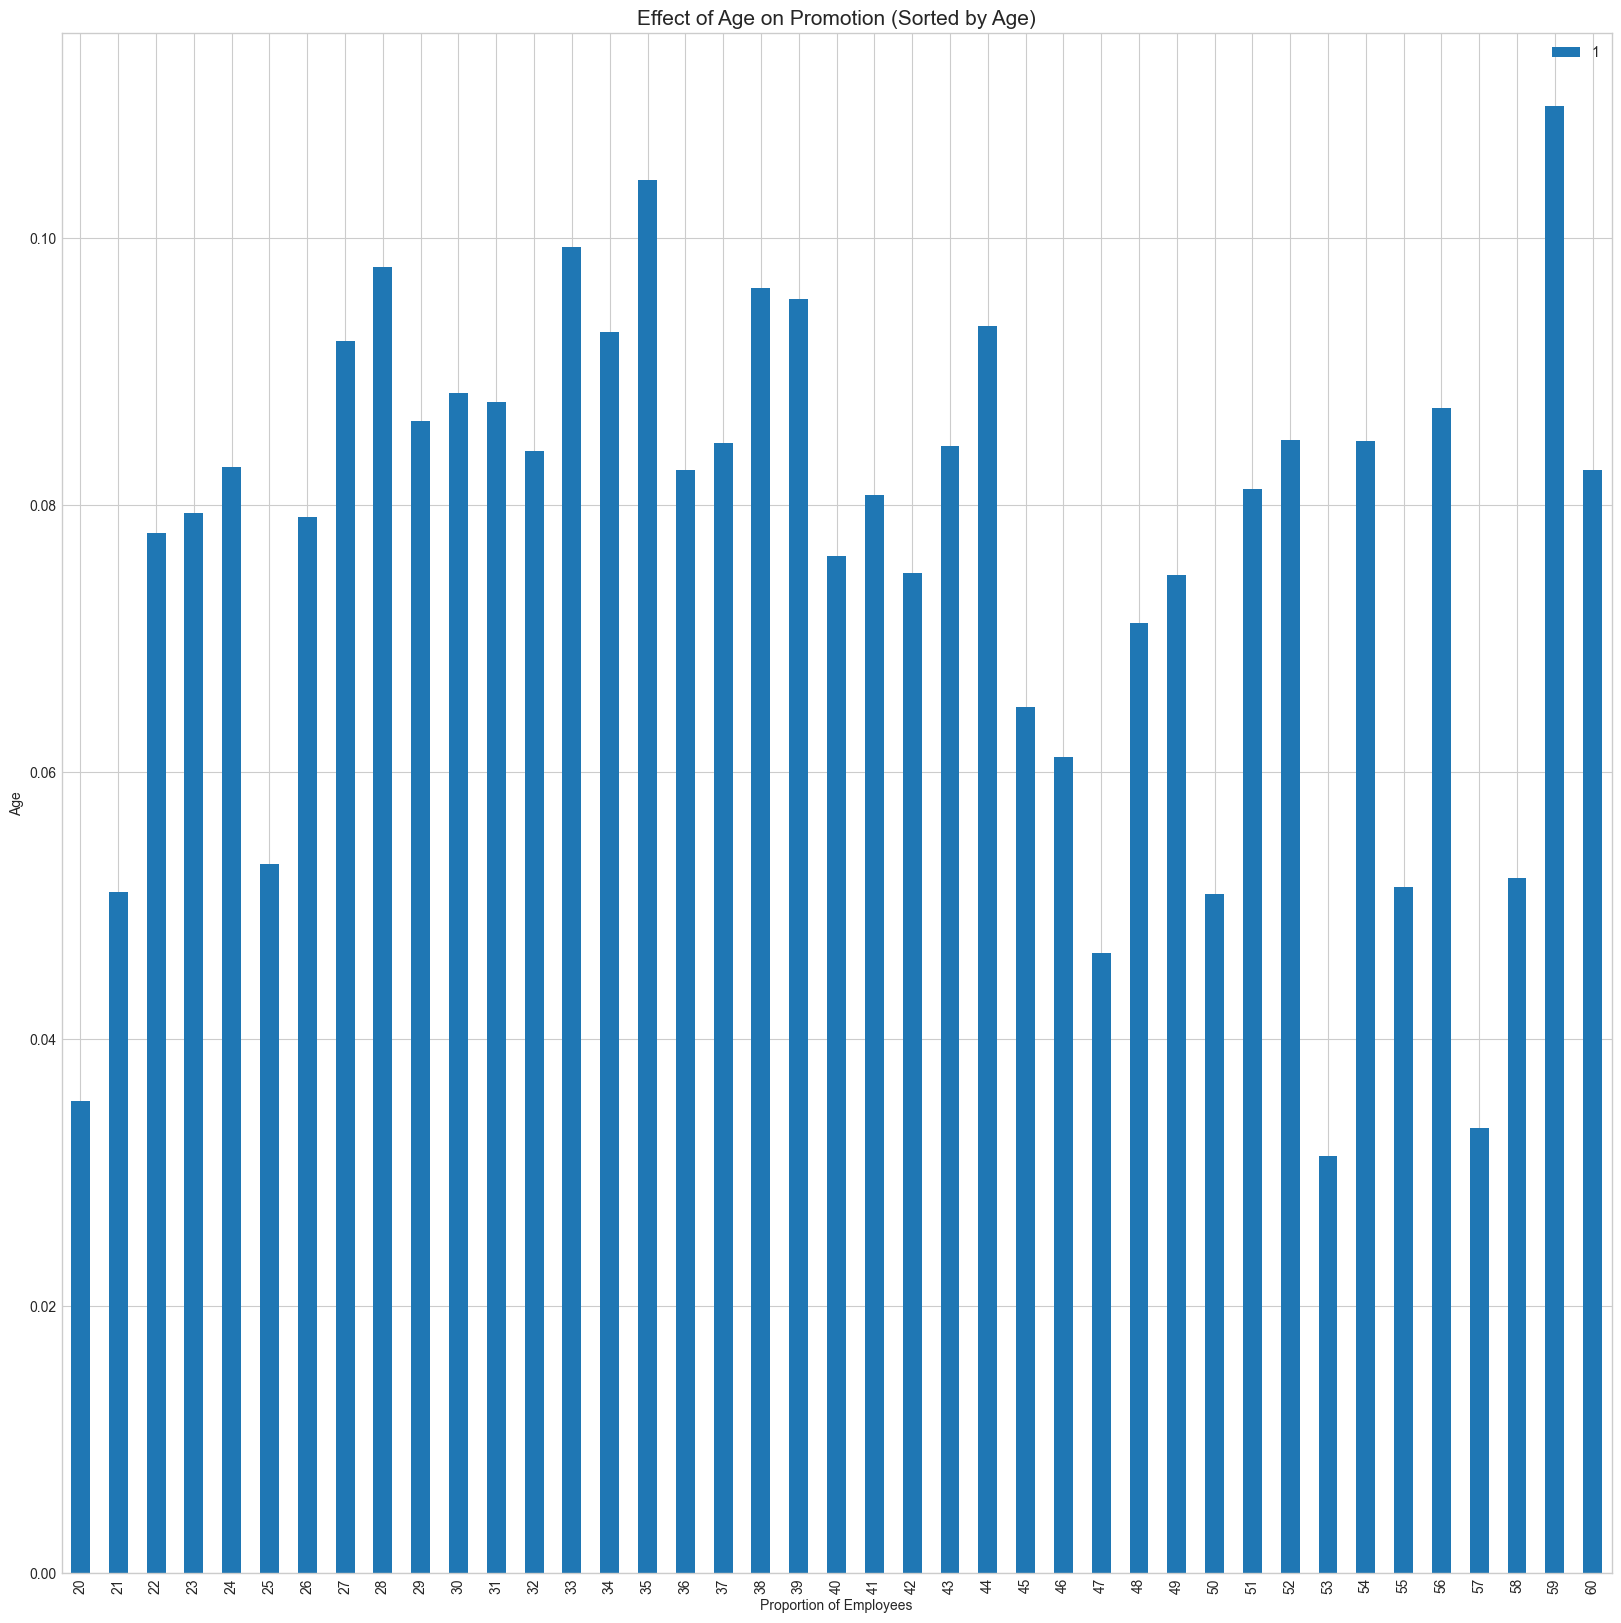

In [ ]:
# Viewing promotion rates by employee age
# Create crosstab
x = pd.crosstab(train['age'], train['is_promoted'])

# Normalize the data
normalized_x = x.div(x.sum(1).astype(float), axis=0)

# Sort by the index (which is 'age')
sorted_x = normalized_x.sort_index(ascending=True)

# Plot the sorted data
sorted_x[1].plot(kind='bar', figsize=(20, 20), legend=True)
plt.title('Effect of Age on Promotion (Sorted by Age)', fontsize=15)
plt.xlabel('Proportion of Employees')
plt.ylabel('Age')
plt.show()


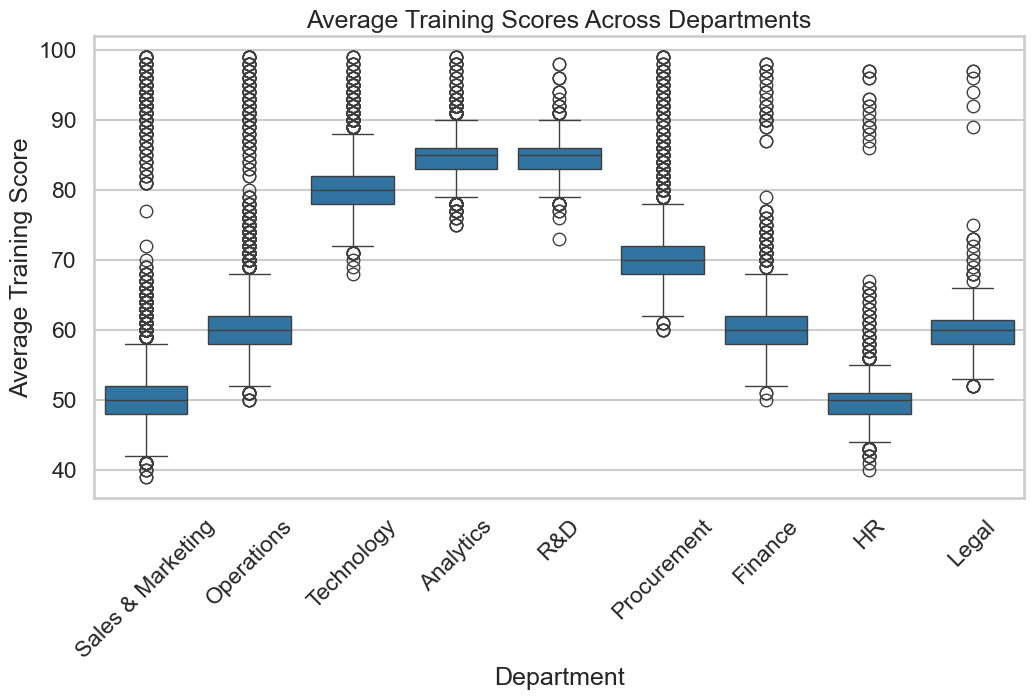

In [ ]:
# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='avg_training_score', data=train)

# Customize the plot
plt.title('Average Training Scores Across Departments')
plt.xlabel('Department')
plt.ylabel('Average Training Score')
plt.xticks(rotation=45)

plt.show()


## Multivariate Analysis

Multivariate analysis is based on the principles of multivariate statistics, which involves observation and analysis of more than one statistical outcome variable at a time.

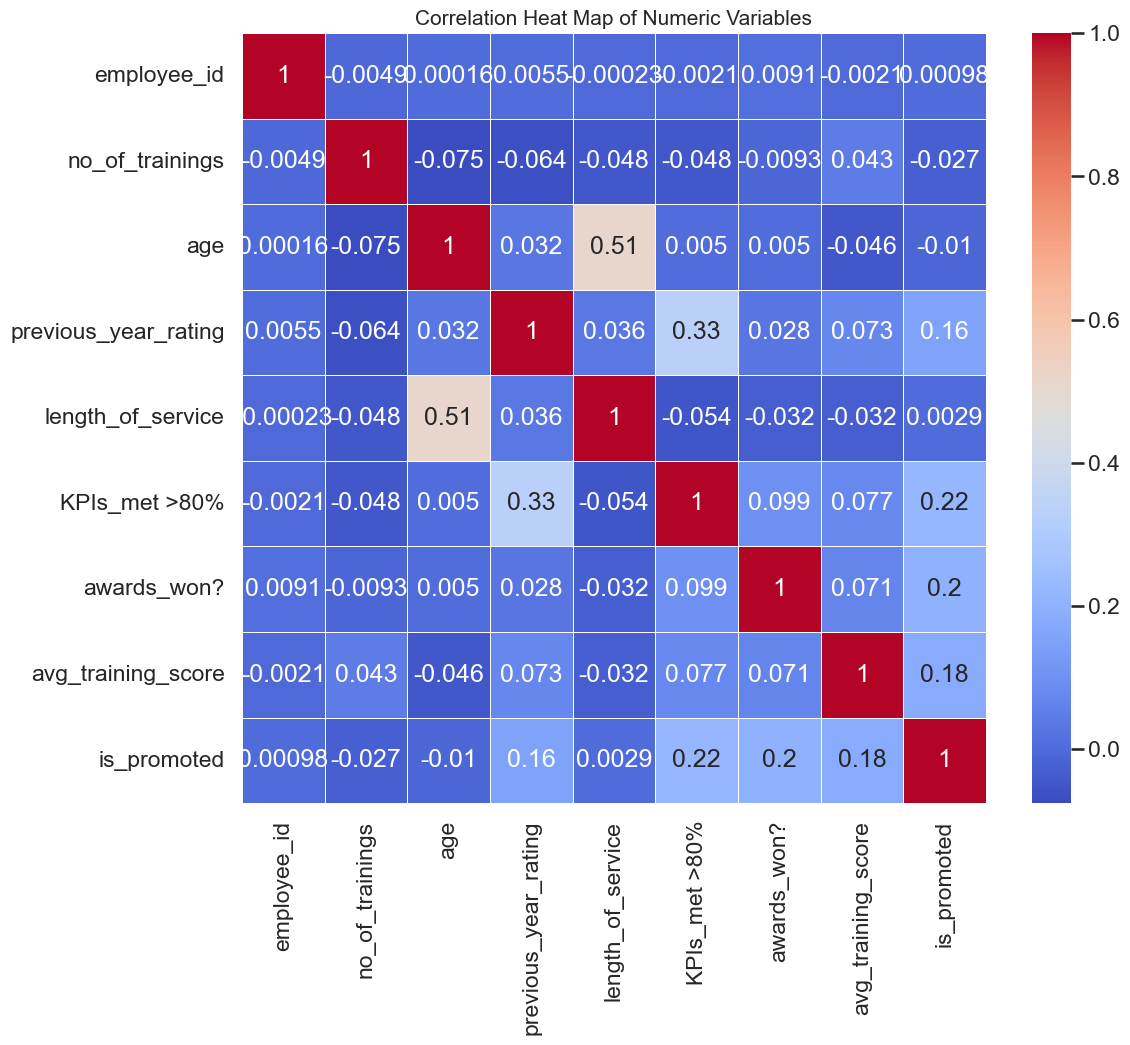

In [ ]:
# Select only numeric columns
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
train_numeric = train[numeric_cols]

# Compute the correlation matrix
corr_matrix = train_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, cmap='coolwarm')
plt.title('Correlation Heat Map of Numeric Variables', fontsize=15)
plt.show()



#### Findings:
* Length of Service, and Age are Highly Correlated,
* KPIs Met and Previous year rating are correlated to some extent, hinting that there is some relation.

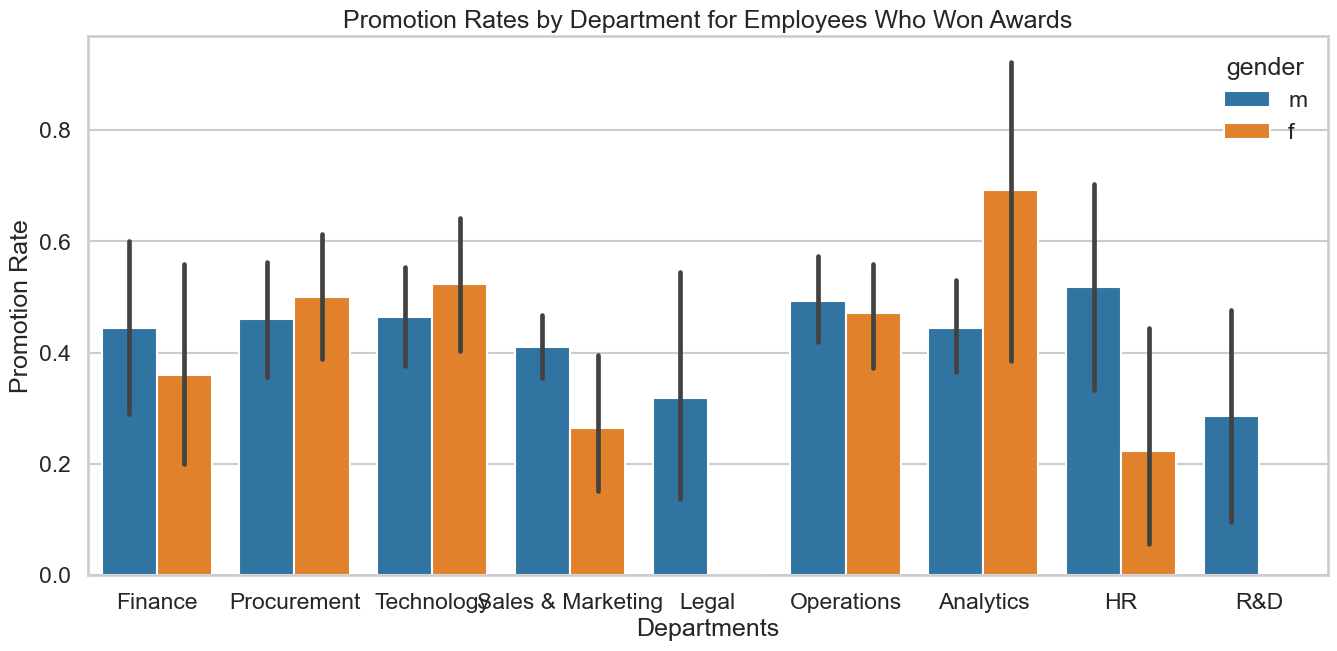

In [ ]:
# Create a bar plot showing the promotion rate by department for employees who have won awards
sns.barplot(x='department', y='is_promoted', hue='gender', data=train[train['awards_won?'] == 1])

# Set the title and labels
plt.title('Promotion Rates by Department for Employees Who Won Awards')
plt.ylabel('Promotion Rate')
plt.xlabel('Departments')

plt.show()


## Feature Engineering

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself.


* Feature engineering techniques:
    * Removing unnecessary columns
    * Extracting features from the date and time features.
    * Extracting features from the categorcial features.
    * Binnning the numerical and categorical features.
    * Aggregating multiple features together by using simple arithmetic operations

In this analysis a feature engineering will be performed by aggregegating features together.


In [ ]:
# Creating extra features from existing features to improve the model

# Creating a Metric of Sum
train['sum_metric'] = train['awards_won?']+train['KPIs_met >80%'] + train['previous_year_rating']
test['sum_metric'] = test['awards_won?']+test['KPIs_met >80%'] + test['previous_year_rating']

# Creating a total score column
train['total_score'] = train['avg_training_score'] * train['no_of_trainings']
test['total_score'] = test['avg_training_score'] * test['no_of_trainings']

*Before going further*:
Performing an outlier check of employees who did not get an award, achieve 80+ of their KPI goals, recieved a previous year rating of 1, and average training score is less than 40 but still got promoted.

Based on the analysis so far, this shouldn't be very common. Thus, any results will be outliers in need of removal.

In [ ]:
train[(train['KPIs_met >80%'] == 0) & (train['previous_year_rating'] == 1.0) &
      (train['awards_won?'] == 0) & (train['avg_training_score'] < 60) & (train['is_promoted'] == 1)]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
31860,29663,Sales & Marketing,region_22,Bachelor's,m,referred,1,27,1.0,2,0,0,58,1,1.0,58
51374,28327,Sales & Marketing,region_2,Bachelor's,m,sourcing,1,31,1.0,5,0,0,58,1,1.0,58


In [ ]:
# Removing the outliers:

# DF Shape size before removal
print("Before Deleting the above two rows :", train.shape)

train = train.drop(train[(train['KPIs_met >80%'] == 0) & (train['previous_year_rating'] == 1.0) &
      (train['awards_won?'] == 0) & (train['avg_training_score'] < 60) & (train['is_promoted'] == 1)].index)

# DF Shape Size after removal
print("After Deletion of the above two rows :", train.shape)

Before Deleting the above two rows : (51319, 16)
After Deletion of the above two rows : (51317, 16)


## Dealing with Categorical Columns

Categorical variables are known to hide and mask lots of interesting information in a data set. Methods to deal with categorial data:

* There are various ways to encode categorical columns into numerical columns (which is an essential step when working with machine learning models which work with numbers only)

Columns in the data set that need encoding:
* Education, Department and Gender

In [ ]:
## Checking categorical columns present in the data
train.select_dtypes('object').head()

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


In [ ]:
# Checking the value counts for the education column
train['education'].value_counts()

education
Bachelor's          37346
Master's & above    13166
Below Secondary       805
Name: count, dtype: int64

In [ ]:
# Encoding Education Columns:

# Encoding the education column in degree of importance
train['education'] = train['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"), (3, 2, 1))

test['education'] = test['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"), (3, 2, 1))

In [ ]:
# Encoding the remaining columns
le = LabelEncoder()
train['department'] = le.fit_transform(train['department'])
test['department'] = le.fit_transform(test['department'])
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.fit_transform(test['gender'])

# Checking remaining categorical columns that lack encoding
print(train.select_dtypes('object').columns)
print(test.select_dtypes('object').columns)

Index(['region', 'recruitment_channel'], dtype='object')
Index(['region', 'recruitment_channel'], dtype='object')


In [ ]:
# Dropping un-encoded, but also not-useful columns from the dataset
train = train.drop(['employee_id','region', 'recruitment_channel'], axis=1)
test = train.drop(['employee_id','region', 'recruitment_channel'], axis=1)


In [ ]:
# Preview of the data to double-check the dataset
train.head()

,department,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
0,7,3,0,1,35,5.0,8,1,0,49,0,6.0,49
1,4,2,1,1,30,5.0,4,0,0,60,0,5.0,60
2,7,2,1,1,34,3.0,7,0,0,50,0,3.0,50
3,7,2,1,2,39,1.0,10,0,0,50,0,1.0,100
4,8,2,1,1,45,3.0,2,0,0,73,0,3.0,73


## Splitting the Data

This is one of the most important steps to perform when performing working with machine learning models.

Steps necessary:
* Separatation of the target and independent Columns.
  * The target variable will be stored in y as it is depedent; the rest of the columns will be stored in x


In [ ]:
# Splitting the target variable from the dataset

y = train['is_promoted']
x = train.drop(['is_promoted'], axis = 1)
x_test = test

# Viewing the DF Shape Size of the split data
print("Shape of the x :", x.shape)
print("Shape of the y :", y.shape)
print("Shape of the x Test :", x_test.shape)

Shape of the x : (51317, 12)
Shape of the y : (51317,)
Shape of the x Test : (23490, 12)


## Resampling

Resampling is the method that consists of drawing repeated samples from the original data samples. The method of Resampling is a nonparametric method of statistical inference.

* Earlier in the analysis, it was observed that the target column is highly imbalanced. Statistical methods can be used to rebalance the data, some techniques include:
    * Over Samping
    * Cluster based Sampling
    * Under Sampling.
    
Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set. These terms are used both in statistical sampling, survey design methodology and in machine learning. Oversampling and undersampling are opposite and roughly equivalent techniques

For this analysis the over sampling technique will be used to avoid data loss.

In [ ]:
# Resampling the data since it is highly imbalanced; making this an essential step.
# Over Sampling Technique is the method that will be used to resample the data using SMOTE


# Oversampling using SMOTE
x_resample, y_resample = SMOTE().fit_resample(x, y.values.ravel())

# Printing DF shapes of the resampled data
print("After Resampling:")
print("x_resample shape:", x_resample.shape)
print("y_resample shape:", y_resample.shape)

After Resampling:
x_resample shape: (93770, 12)
y_resample shape: (93770,)


In [ ]:
# Printing Target Variable counts after resampling

print("Before Resampling :")
print(y.value_counts())

print("After Resampling :")
y_resample = pd.DataFrame(y_resample)
print(y_resample[0].value_counts())

Before Resampling :
is_promoted
0    46885
1     4432
Name: count, dtype: int64
After Resampling :
0
0    46885
1    46885
Name: count, dtype: int64


In [2]:
# Creating a validation set from the training data to check whether the model created is good enough; using train_test_split library from sklearn

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 0)

# Printing the DF Shape Sizes
print("Shape of the x Train :", x_train.shape)
print("Shape of the y Train :", y_train.shape)
print("Shape of the x Valid :", x_valid.shape)
print("Shape of the y Valid :", y_valid.shape)
print("Shape of the x Test :", x_test.shape)

NameError: name 'x_resample' is not defined

## Feature Scaling

Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.

In [ ]:
# Feature Scaling using the standardization method

# lets import the standard scaler library from sklearn to do that
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)


##  Machine Learning Predictive Modelling

Predictive modeling is a process that uses data and statistics to predict outcomes with data models. These models can be used to predict anything from sports outcomes and TV ratings to technological advances and corporate earnings. Predictive modeling is also often referred to as: Predictive analytics.

### Decision Tree Classifier

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

In [ ]:
# Using the Decision Trees Model to classify the data
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

Training Accuracy : 0.9904553695211689
Testing Accuracy : 0.9351071771355444


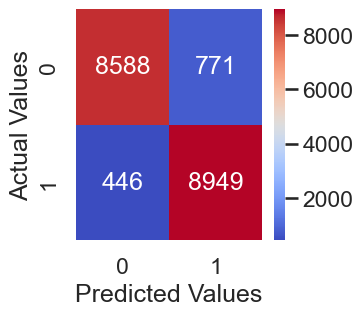

In [ ]:
# Printing the test accuracy and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

print("Training Accuracy :", model.score(x_train, y_train))
print("Testing Accuracy :", model.score(x_valid, y_valid))

cm = confusion_matrix(y_valid, y_pred)
plt.rcParams['figure.figsize'] = (3, 3)
sns.heatmap(cm, annot = True, cmap = 'coolwarm', fmt = '.8g')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [ ]:
# Printing the classification report

cr = classification_report(y_valid, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      9359
           1       0.92      0.95      0.94      9395

    accuracy                           0.94     18754
   macro avg       0.94      0.94      0.94     18754
weighted avg       0.94      0.94      0.94     18754



## Real Time Prediction

In [ ]:
train.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,51319.000000,51319.000000,51319.000000,51319.000000,51319.000000,51319.000000,51319.000000,51319.000000,51319.000000
mean,39187.604045,1.258774,33.828913,3.304624,5.065746,0.359458,0.024163,63.476198,0.086401
std,22575.608312,0.615186,6.762770,1.213732,2.905685,0.479846,0.153555,13.437670,0.280958
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19699.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39176.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58727.500000,1.000000,37.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,13.000000,1.000000,1.000000,99.000000,1.000000
